<a href="https://colab.research.google.com/github/fv-123/LSTM-MLP-MeanVariance-project/blob/main/return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Return Forecasting w/ MC Dropout Uncertainty:
HHS.VN_Close: E[Return]=0.0024±0.0021, E[Std]=0.0170, DirAcc=41.1%±3.9%
HAH.VN_Close: E[Return]=0.0031±0.0020, E[Std]=0.0136, DirAcc=57.6%±3.9%
VCB.VN_Close: E[Return]=0.0021±0.0007, E[Std]=0.0060, DirAcc=57.0%±3.9%
VIX.VN_Close: E[Return]=-0.0076±0.0026, E[Std]=0.0203, DirAcc=52.5%±4.0%
LPB.VN_Close: E[Return]=0.0070±0.0015, E[Std]=0.0140, DirAcc=53.8%±4.0%

Portfolio-Level Summary:
MAE=0.0287±0.0021, RMSE=0.0390±0.0031, DirAcc=53.8%±4.0%, AvgUnc=0.0142


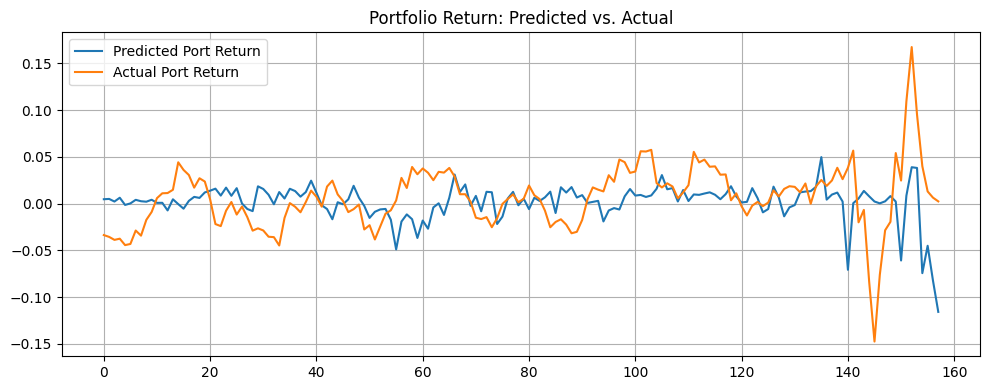

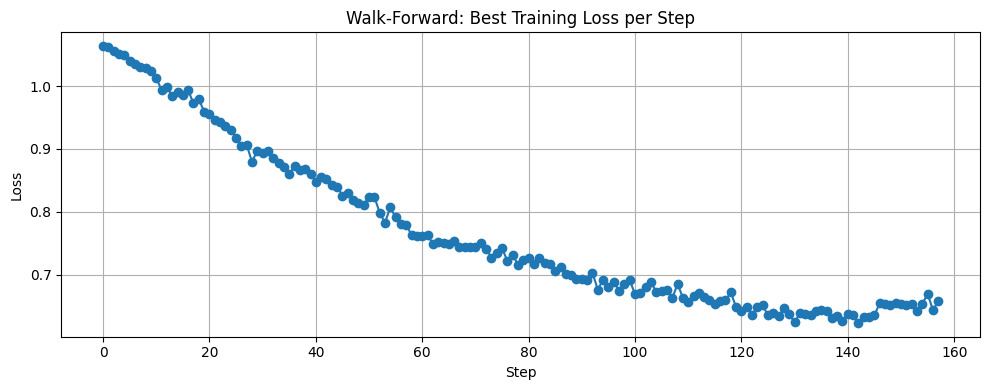

Return model results saved to 'return_model_results.pkl'


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pickle

# --- Configuration ---
horizon      = 7
k            = 6
initial_frac = 0.80
seed         = 42

mc_samples   = 90     # MC dropout passes
max_epochs   = 50     # max epochs per step
lr           = 3e-4
bce_weight   = 1.1    # weight for direction loss
dropout_p    = 0.3
es_patience  = 4      # early-stop patience

# --- Feature toggles ---
use_rsi   = True    # include RSI
use_macd  = False    # include MACD
use_dow   = True    # include day-of-week dummies
# --- Seed everything ---
def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    os.environ["PYTHONHASHSEED"] = str(s)

set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Load & prepare data ---
df = (
    pd.read_csv("combined_stock_data_wide.csv", parse_dates=["Date"])
      .set_index("Date")
      .dropna()
)
close_cols = [c for c in df.columns if c.endswith("_Close") and "Adj" not in c]
vol_cols   = [c for c in df.columns if c.endswith("_Volume")]
n_assets   = len(close_cols)
# --- Compute returns & horizon target ---
df_ret = np.log(df[close_cols] / df[close_cols].shift(1))
ret_h  = df_ret.rolling(horizon).sum().shift(-horizon)

# --- Feature engineering ---

# Basic price features
mom    = df_ret.rolling(k).mean().shift(1)
ewm5   = df_ret.ewm(span=5, adjust=False).mean().shift(1)
vol    = df_ret.rolling(k).std().shift(1)
zscore = (df_ret - df_ret.rolling(k).mean()) / (vol + 1e-8)
mr     = -np.sign(zscore)

# Liquidity
liq = (
    np.log1p(df[vol_cols])
      .diff()
      .ewm(span=horizon, adjust=False)
      .mean()
      .shift(1)
)
liq.columns = [c.replace("_Volume", "_liq") for c in liq.columns]

# Day-of-week
if use_dow:
    dow = pd.get_dummies(df.index.dayofweek, prefix="dow").set_index(df.index)
else:
    dow = pd.DataFrame(index=df.index)

# RSI
if use_rsi:
    rsi_list = []
    window = 6
    for col in close_cols:
        delta    = df[col].diff()
        gain     = delta.clip(lower=0)
        loss     = -delta.clip(upper=0)
        avg_gain = gain.rolling(window).mean()
        avg_loss = loss.rolling(window).mean()
        rs       = avg_gain / (avg_loss + 1e-8)
        rsi      = 100 - 100 / (1 + rs)
        rsi_list.append(rsi.rename(f"{col}_rsi14"))
    rsi_df = pd.concat(rsi_list, axis=1)
else:
    rsi_df = pd.DataFrame(index=df.index)

# MACD
if use_macd:
    macd_list, signal_list = [], []
    for col in close_cols:
        ema12  = df[col].ewm(span=6, adjust=False).mean()
        ema26  = df[col].ewm(span=12, adjust=False).mean()
        macd   = ema12 - ema26
        signal = macd.ewm(span=4, adjust=False).mean()
        macd_list.append(macd.rename(f"{col}_macd"))
        signal_list.append(signal.rename(f"{col}_macd_sig"))
    macd_df     = pd.concat(macd_list, axis=1)
    macd_sig_df = pd.concat(signal_list, axis=1)
else:
    macd_df     = pd.DataFrame(index=df.index)
    macd_sig_df = pd.DataFrame(index=df.index)
# Align & drop NaNs
common = mom.index
for part in [ewm5, vol, mr, liq, ret_h, dow, rsi_df, macd_df, macd_sig_df]:
    common = common.intersection(part.index)

X_df = pd.concat(
    [mom, ewm5, vol, mr, liq, rsi_df, macd_df, macd_sig_df, dow], axis=1
).loc[common].dropna()
y_df = ret_h.loc[X_df.index]
mask = ~y_df.isna().any(axis=1)
X_df, y_df = X_df.loc[mask], y_df.loc[mask]
# Train/Test split & scaling
T           = X_df.shape[0]
train_size  = int(initial_frac * T)
steps       = T - train_size

X_scaler = StandardScaler().fit(X_df.values[:train_size])
X_all    = X_scaler.transform(X_df.values)

y_scaler = StandardScaler().fit(y_df.values[:train_size])
y_all    = y_scaler.transform(y_df.values)
# --- Model definition ---
class MultiTaskMLP(nn.Module):
    def __init__(self, in_dim, n_assets, hidden=64, p=dropout_p):
        super().__init__()
        self.shared   = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Dropout(p)
        )
        self.ret_head = nn.Linear(hidden, n_assets)
        self.dir_head = nn.Linear(hidden, n_assets)

    def forward(self, x):
        h = self.shared(x)
        return self.ret_head(h), self.dir_head(h)

mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()

model     = MultiTaskMLP(X_all.shape[1], n_assets).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# Storage
h_preds_orig, h_stds_orig, dir_accs, true_vals = [], [], [], []
step_losses = []

# --- Walk-forward loop ---
for t in range(steps):
    end    = train_size + t
    X_tr   = X_all[:end];        y_tr   = y_all[:end]
    dir_tr = (y_scaler.inverse_transform(y_tr) > 0).astype(float)

    X_tr_t = torch.tensor(X_tr, dtype=torch.float32, device=device)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32, device=device)
    d_tr_t = torch.tensor(dir_tr, dtype=torch.float32, device=device)

    best_loss, patience = float("inf"), 0
    best_state = None

    for _ in range(max_epochs):
        model.train(); optimizer.zero_grad()
        r_pred, d_logit = model(X_tr_t)
        loss = mse_loss(r_pred, y_tr_t) + bce_weight * bce_loss(d_logit, d_tr_t)
        val  = loss.item()
        if val < best_loss:
            best_loss, best_state, patience = val, {k:v.cpu().clone() for k,v in model.state_dict().items()}, 0
        else:
            patience += 1
            if patience >= es_patience:
                break
        loss.backward(); optimizer.step()

    model.load_state_dict(best_state)
    step_losses.append(best_loss)

    # Inference
    X_te = X_all[end:end+1];  y_te = y_df.values[end]
    model.train()
    X_te_t = torch.tensor(X_te, dtype=torch.float32, device=device)
    ret_samps, dir_samps = [], []
    with torch.no_grad():
        for _ in range(mc_samples):
            rs, ds = model(X_te_t)
            ret_samps.append(rs.cpu().numpy()[0])
            dir_samps.append(torch.sigmoid(ds).cpu().numpy()[0])

    ret_samps = np.stack(ret_samps)
    dir_samps = np.stack(dir_samps)

    mean_ret_s = ret_samps.mean(axis=0)
    std_ret_s  = ret_samps.std(axis=0)

    mean_ret_o = y_scaler.inverse_transform(mean_ret_s.reshape(1,-1))[0]
    std_ret_o  = std_ret_s * y_scaler.scale_

    dir_pred = (dir_samps.mean(axis=0) > 0.5).astype(float)
    dir_true = (y_te > 0).astype(float)
    dir_acc  = (dir_pred == dir_true).astype(float)

    h_preds_orig.append((mean_ret_o, X_df.index[end]))  # Added date as tuple
    h_stds_orig.append(std_ret_o)
    dir_accs.append(dir_acc)
    true_vals.append(y_te)
# --- Aggregate & report ---
h_preds_arr = np.vstack([p for p, _ in h_preds_orig])  # Unpack predictions
h_stds_arr  = np.vstack(h_stds_orig)
dir_arr     = np.vstack(dir_accs)

print("\nReturn Forecasting w/ MC Dropout Uncertainty:")
for i,col in enumerate(close_cols):
    mu, se_mu = h_preds_arr[:,i].mean(), h_preds_arr[:,i].std(ddof=1)/np.sqrt(len(h_preds_arr))
    sigma     = h_stds_arr[:,i].mean()
    da, se_da = dir_arr[:,i].mean()*100, np.sqrt(dir_arr[:,i].mean()*(1-dir_arr[:,i].mean())/len(dir_arr))*100
    print(f"{col}: E[Return]={mu:.4f}±{se_mu:.4f}, E[Std]={sigma:.4f}, DirAcc={da:.1f}%±{se_da:.1f}%")

# Portfolio summary
w     = np.ones(n_assets)/n_assets
predp = h_preds_arr.dot(w)
truep = np.array(true_vals).dot(w)
maep  = mean_absolute_error(truep, predp)
se_maep = np.std(np.abs(predp-truep),ddof=1)/np.sqrt(len(predp))
rmsep = np.sqrt(mean_squared_error(truep, predp))
se_rmsep = np.std((predp-truep)**2,ddof=1)/(2*rmsep*np.sqrt(len(predp)))
darp = (dir_arr.dot(w)>0.5).mean()*100
se_darp = np.sqrt(darp/100*(1-darp/100)/len(dir_arr))*100
avg_unc = h_stds_arr.dot(w).mean()

print("\nPortfolio-Level Summary:")
print(f"MAE={maep:.4f}±{se_maep:.4f}, RMSE={rmsep:.4f}±{se_rmsep:.4f}, "
      f"DirAcc={darp:.1f}%±{se_darp:.1f}%, AvgUnc={avg_unc:.4f}")

# Plots
plt.figure(figsize=(10,4))
plt.plot(predp,  label='Predicted Port Return')
plt.plot(truep,  label='Actual Port Return')
plt.title("Portfolio Return: Predicted vs. Actual"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(step_losses, marker='o')
plt.title("Walk-Forward: Best Training Loss per Step"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True); plt.tight_layout(); plt.show()

# Save results
with open('return_model_results.pkl', 'wb') as f:
    pickle.dump({'h_preds_orig': h_preds_orig, 'h_stds_orig': h_stds_orig, 'dir_accs': dir_accs, 'true_vals': true_vals, 'close_cols': close_cols}, f)
print("Return model results saved to 'return_model_results.pkl'")

In [ ]:
grid_search_params = [
    {
        "horizon": 7,
        "k": 6,
        "initial_frac": 0.80,
        "seed": 42,
        "mc_samples": mc,
        "max_epochs": ep,
        "lr": lr,
        "bce_weight": bw,
        "dropout_p": dp,
        "es_patience": 4
    }
    for mc in [60, 90, 120]
    for ep in [30, 50, 70]
    for lr in [1e-4, 3e-4, 5e-4]
    for bw in [1.0, 1.1, 1.3]
    for dp in [0.2, 0.3, 0.5]
]
